# BKT Experiments - Quick Start Guide

This notebook demonstrates the basic functionality of the BKT experimental framework.

## Setup

In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, str(Path.cwd().parent))

from data.mock_generator import MockDataGenerator, LearnerProfile
from models.bkt.standard_bkt import StandardBKT, BKTParameters
from analysis.metrics import compute_all_metrics, print_metric_summary
from analysis.visualizations import *

print("Imports successful!")

✓ Imports successful!


## 1. Generate Mock Data

Create a synthetic dataset with diverse learner profiles.

In [4]:
# Create data generator
generator = MockDataGenerator(seed=42)

# Generate dataset
dataset = generator.generate_dataset(
    num_students=100,
    num_skills=3,
    skill_names=["Limits", "Derivatives", "Integrals"],
    min_attempts_per_student=30,
    max_attempts_per_student=60
)

print(f"Dataset Statistics:")
print(f"  Students: {dataset.num_students}")
print(f"  Skills: {len(dataset.skills)}")
print(f"  Items: {len(dataset.items)}")
print(f"  Total interactions: {dataset.num_interactions}")

# Show learner profile distribution
profiles = {}
for seq in dataset.sequences:
    profile = seq.metadata.get('profile', 'Unknown')
    profiles[profile] = profiles.get(profile, 0) + 1

print("\nLearner Profiles:")
for profile, count in profiles.items():
    print(f"  {profile}: {count}")

Dataset Statistics:
  Students: 100
  Skills: 3
  Items: 60
  Total interactions: 4672

Learner Profiles:
  Fast Learner: 18
  Prior Knowledge: 26
  Average: 18
  Slow Learner: 21
  Struggling: 17


## 2. Fit Standard BKT Model

Train a standard BKT model using the EM algorithm.

In [5]:
# Create and fit model
model = StandardBKT()

print("Fitting BKT model...")
model.fit(dataset, max_iterations=50, tolerance=1e-4, verbose=True)

Fitting BKT model...
Fitting Standard BKT on 100 students...
Iteration 0: Log-likelihood = -2448.6228
Converged at iteration 6
Training completed. Final log-likelihood: -2450.0216

Learned parameters:
  skill_00: L0=0.200, T=0.150, G=0.229, S=0.134
  skill_01: L0=0.200, T=0.150, G=0.225, S=0.145
  skill_02: L0=0.200, T=0.150, G=0.262, S=0.130


### Learned Parameters

In [6]:
# Display learned parameters
params_df = pd.DataFrame([
    {
        'Skill': dataset.skills[skill_id].name,
        **model.get_parameters(skill_id)
    }
    for skill_id in sorted(model.skills_params.keys())
])

print("\nLearned BKT Parameters:")
print(params_df.to_string(index=False, float_format='%.4f'))


Learned BKT Parameters:
      Skill  p_init  p_learn  p_guess  p_slip
     Limits  0.2000   0.1500   0.2293  0.1342
Derivatives  0.2000   0.1500   0.2248  0.1452
  Integrals  0.2000   0.1500   0.2625  0.1299


## 3. Evaluate Model Performance

In [7]:
# Evaluate on the dataset
metrics = model.evaluate(dataset)

print_metric_summary(metrics, title="BKT Model Performance")


                   BKT Model Performance                    

Accuracy Metrics:
  AUC         : 0.7974
  ACCURACY    : 0.7463

Error Metrics:
  RMSE        : 0.4154
  LOG_LOSS    : 0.5199



## 4. Visualize Learning Trajectory

Show how knowledge state evolves for a single student.

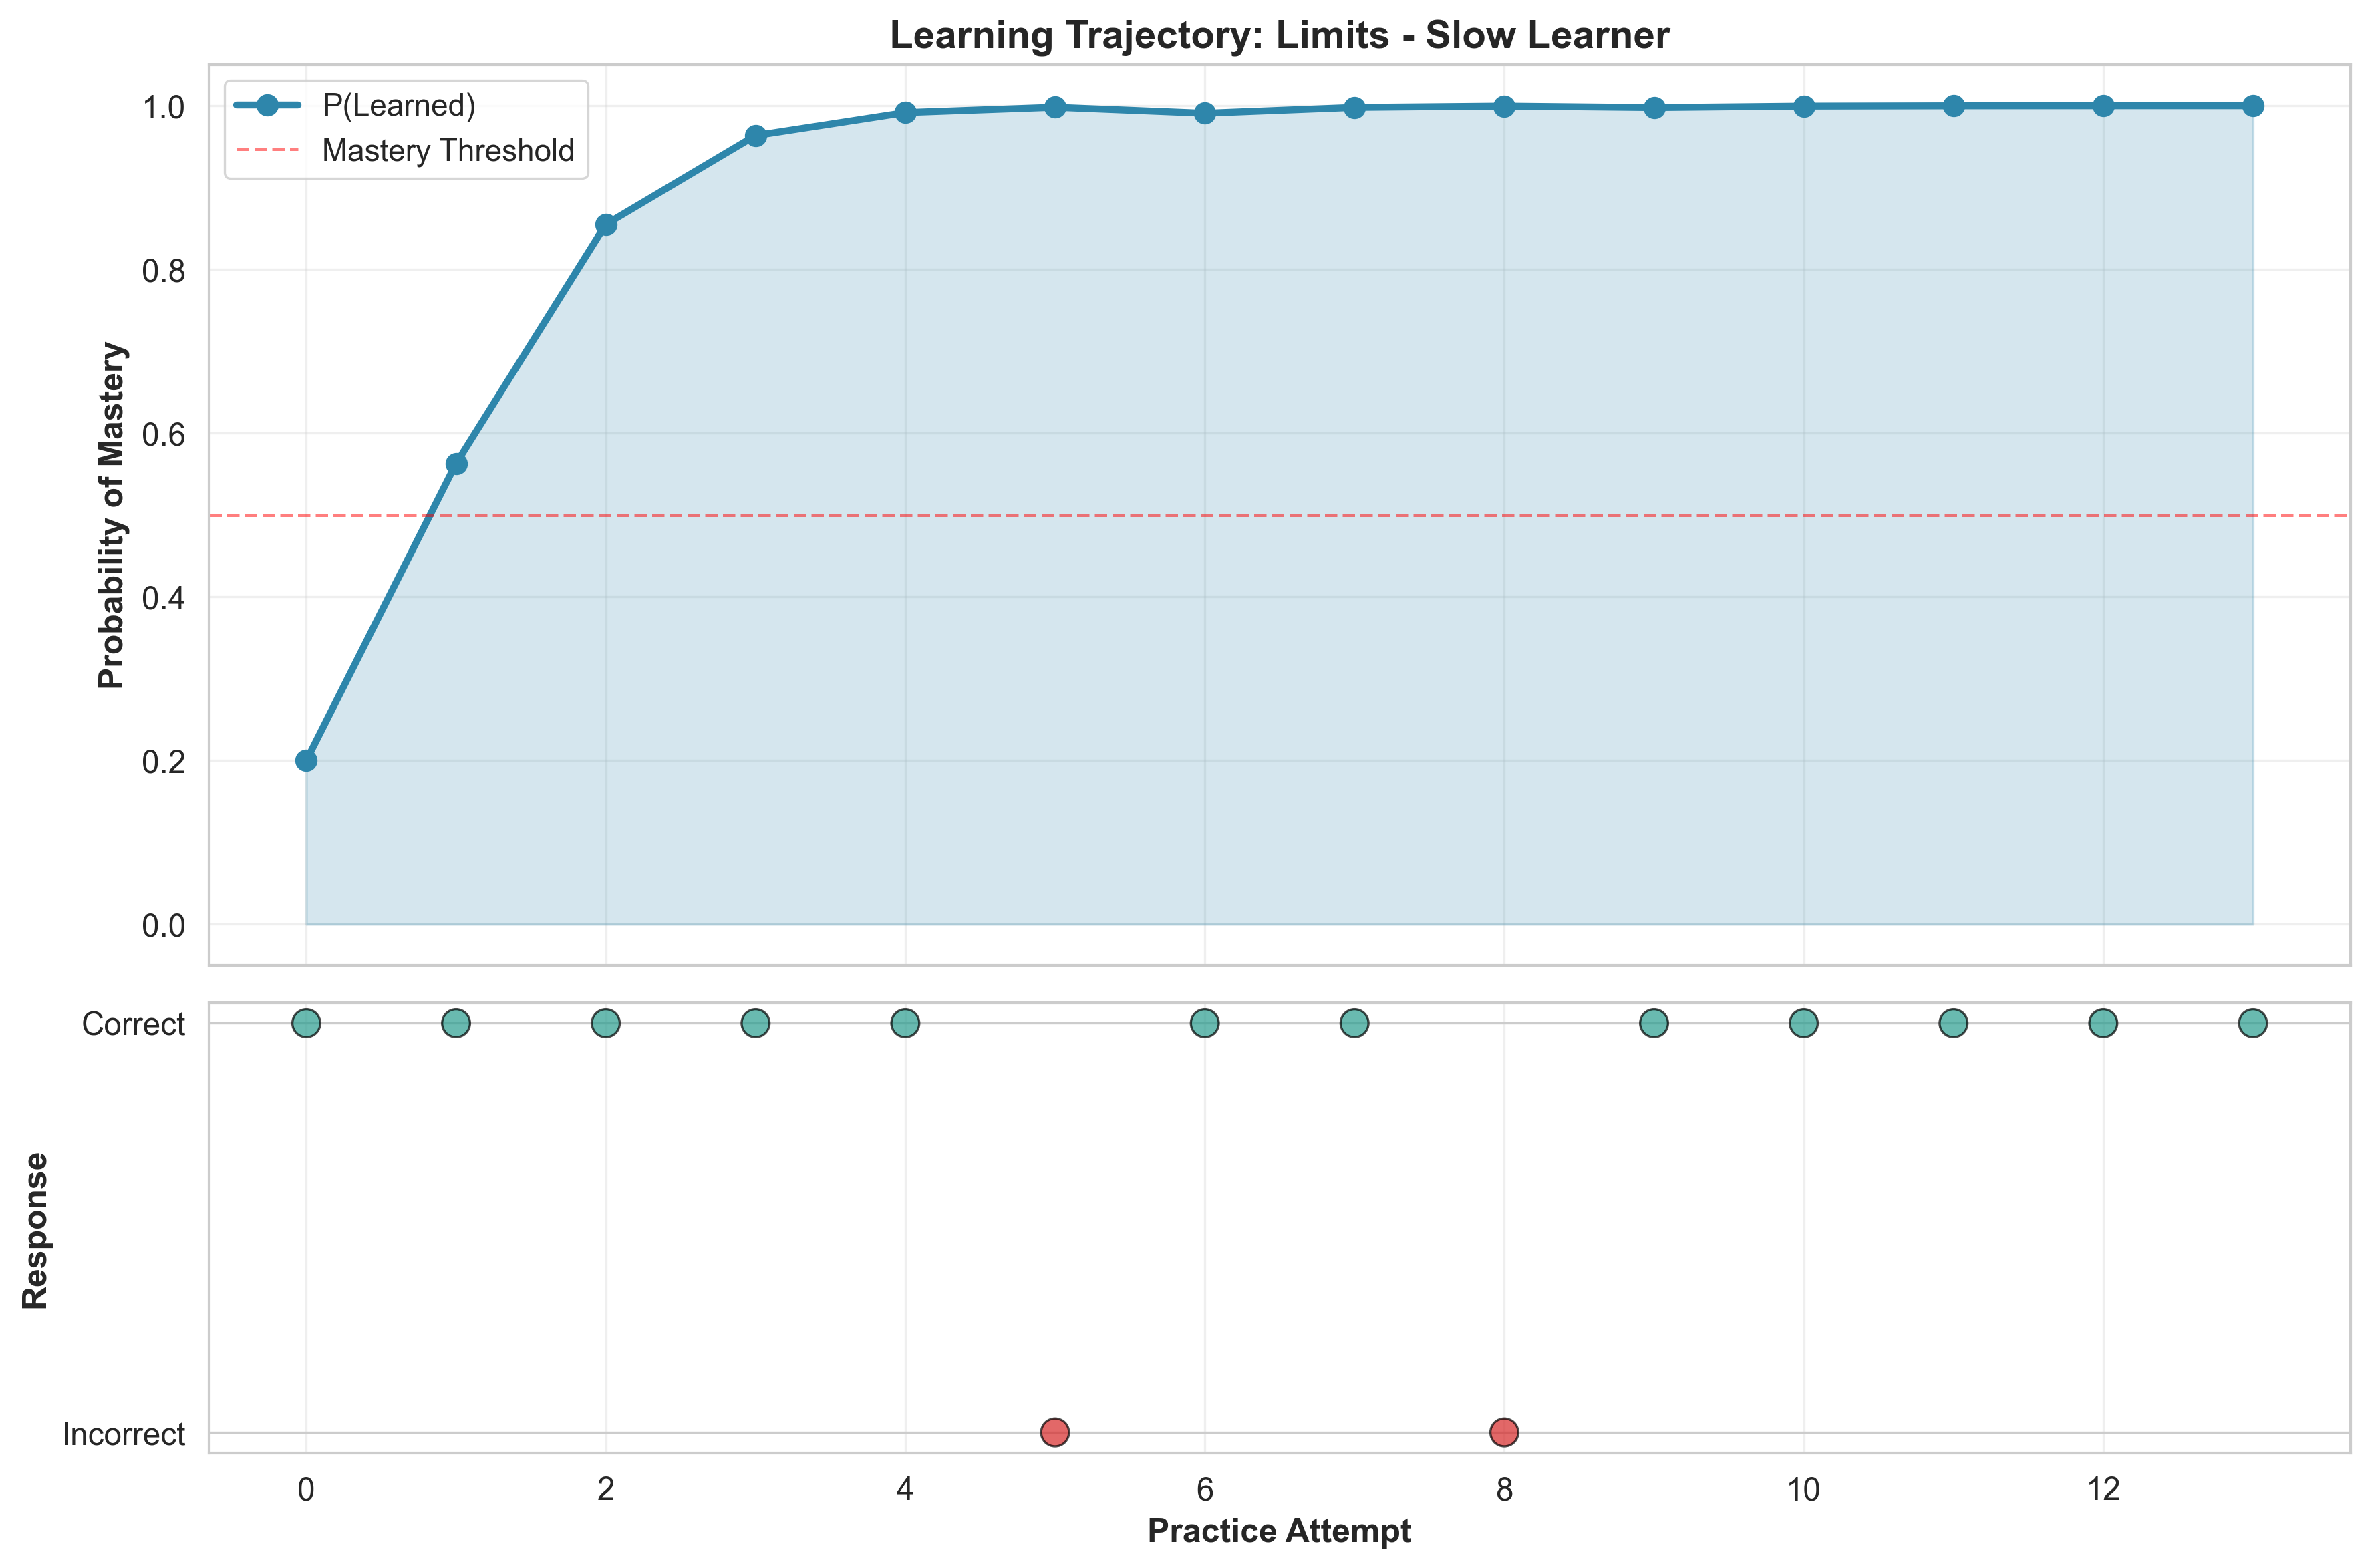

In [8]:
# Select a student
student = dataset.sequences[5]
skill_id = list(dataset.skills.keys())[0]
skill_name = dataset.skills[skill_id].name

# Get interactions for this skill
skill_interactions = [i for i in student.interactions if i.skill_id == skill_id]

if len(skill_interactions) > 5:
    # Compute knowledge states over time
    knowledge_states = []
    responses = []
    
    for i in range(len(skill_interactions)):
        history = skill_interactions[:i]
        p_know = model.get_knowledge_state(student.student_id, skill_id, history)
        knowledge_states.append(p_know)
        responses.append(skill_interactions[i].correct)
    
    # Plot
    plot_learning_trajectory(
        knowledge_states,
        responses,
        skill_name=f"{skill_name} - {student.metadata.get('profile', 'Unknown')}"
    )
else:
    print(f"Not enough data for skill {skill_name}")

## 5. Parameter Sensitivity Analysis

Run a quick sensitivity analysis to see how parameters affect performance.

In [9]:
from experiments.parameter_sensitivity import ParameterSensitivityExperiment

exp = ParameterSensitivityExperiment(output_dir="../results/notebook_experiment")

# Run single parameter sweep for P(T) learning rate
p_learn_sweep = exp.run_single_parameter_sweep(
    parameter_name='p_learn',
    param_range=np.linspace(0.05, 0.40, 15).tolist(),
    dataset=dataset,
    num_trials=1,
    verbose=True
)


Parameter Sensitivity Sweep: p_learn
Testing 15 values with 1 trials each
Base parameters: default



Sweeping p_learn: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


Results saved to: ..\results\notebook_experiment\sweep_p_learn.csv

----------------------------------------------------------------------
Summary for P_LEARN:
----------------------------------------------------------------------
Best value: 0.050
  AUC: 0.8020 (±0.0000)
  Accuracy: 0.7489
  RMSE: 0.4140

Good range (AUC ≥ 0.7218):
  [0.050, 0.400]


### Visualize Sensitivity

Saved to: ../results/notebook_experiment/p_learn_sensitivity.png


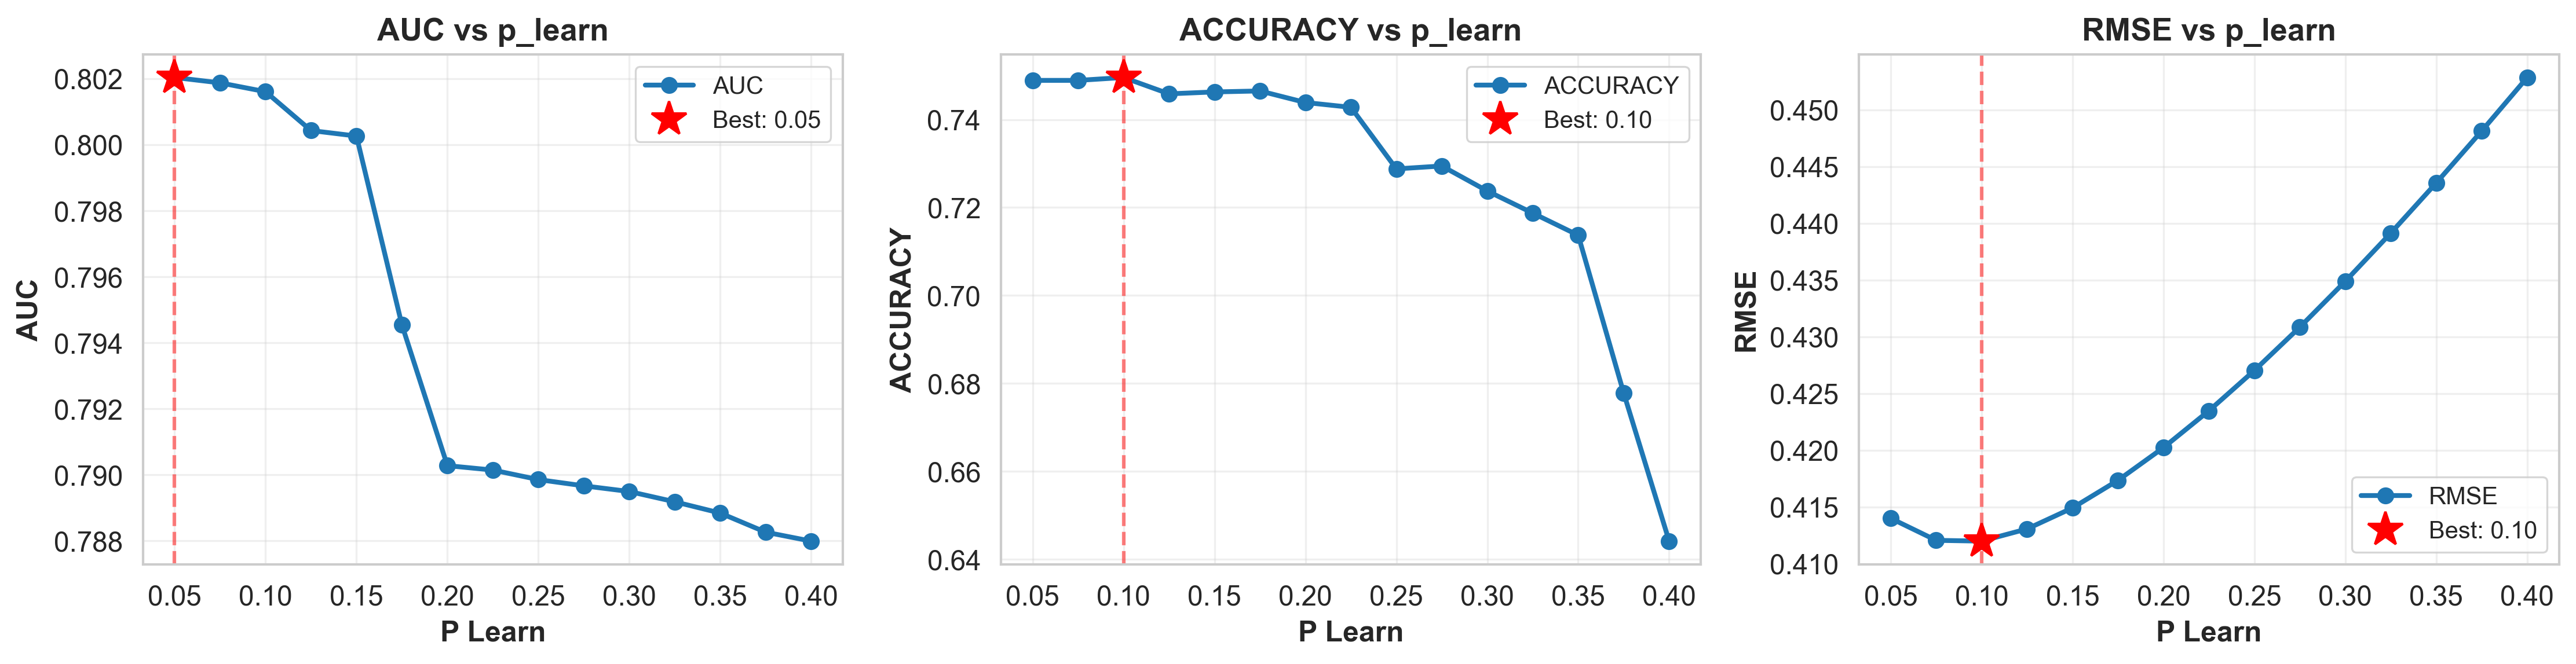

In [10]:
plot_parameter_sensitivity(
    df=p_learn_sweep,
    parameter_name='p_learn',
    metrics=['auc', 'accuracy', 'rmse'],
    save_path='../results/notebook_experiment/p_learn_sensitivity.png'
)

## 6. Run Full Sensitivity Analysis

This will take a few minutes...


Parameter Sensitivity Sweep: p_init
Testing 10 values with 3 trials each
Base parameters: {'p_init': 0.2, 'p_learn': 0.15, 'p_guess': 0.2, 'p_slip': 0.1}



Sweeping p_init: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]



Results saved to: ..\results\notebook_experiment\sweep_p_init.csv

----------------------------------------------------------------------
Summary for P_INIT:
----------------------------------------------------------------------
Best value: 0.500
  AUC: 0.8019 (±0.0000)
  Accuracy: 0.7332
  RMSE: 0.4184

Good range (AUC ≥ 0.7217):
  [0.000, 0.900]

Parameter Sensitivity Sweep: p_learn
Testing 15 values with 3 trials each
Base parameters: {'p_init': 0.2, 'p_learn': 0.15, 'p_guess': 0.2, 'p_slip': 0.1}



Sweeping p_learn: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]



Results saved to: ..\results\notebook_experiment\sweep_p_learn.csv

----------------------------------------------------------------------
Summary for P_LEARN:
----------------------------------------------------------------------
Best value: 0.045
  AUC: 0.8024 (±0.0000)
  Accuracy: 0.7489
  RMSE: 0.4147

Good range (AUC ≥ 0.7222):
  [0.010, 0.500]

Parameter Sensitivity Sweep: p_guess
Testing 9 values with 3 trials each
Base parameters: {'p_init': 0.2, 'p_learn': 0.15, 'p_guess': 0.2, 'p_slip': 0.1}



Sweeping p_guess: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]



Results saved to: ..\results\notebook_experiment\sweep_p_guess.csv

----------------------------------------------------------------------
Summary for P_GUESS:
----------------------------------------------------------------------
Best value: 0.300
  AUC: 0.8004 (±0.0000)
  Accuracy: 0.7458
  RMSE: 0.4165

Good range (AUC ≥ 0.7203):
  [0.050, 0.400]

Parameter Sensitivity Sweep: p_slip
Testing 9 values with 3 trials each
Base parameters: {'p_init': 0.2, 'p_learn': 0.15, 'p_guess': 0.2, 'p_slip': 0.1}



Sweeping p_slip: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]
c:\Users\Windows 11\Desktop\RofProject\SeniorProject\calculus-enhancement-platform\backend\bkt_experiments\analysis\visualizations.py:145: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()



Results saved to: ..\results\notebook_experiment\sweep_p_slip.csv

----------------------------------------------------------------------
Summary for P_SLIP:
----------------------------------------------------------------------
Best value: 0.050
  AUC: 0.8007 (±0.0000)
  Accuracy: 0.7463
  RMSE: 0.4160

Good range (AUC ≥ 0.7206):
  [0.000, 0.400]


c:\Users\Windows 11\Desktop\RofProject\SeniorProject\calculus-enhancement-platform\backend\bkt_experiments\analysis\visualizations.py:150: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig(save_path, bbox_inches='tight', dpi=300)


Saved to: ..\results\notebook_experiment\figures\all_parameters_sensitivity.png


c:\Users\Windows 11\Desktop\RofProject\SeniorProject\calculus-enhancement-platform\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


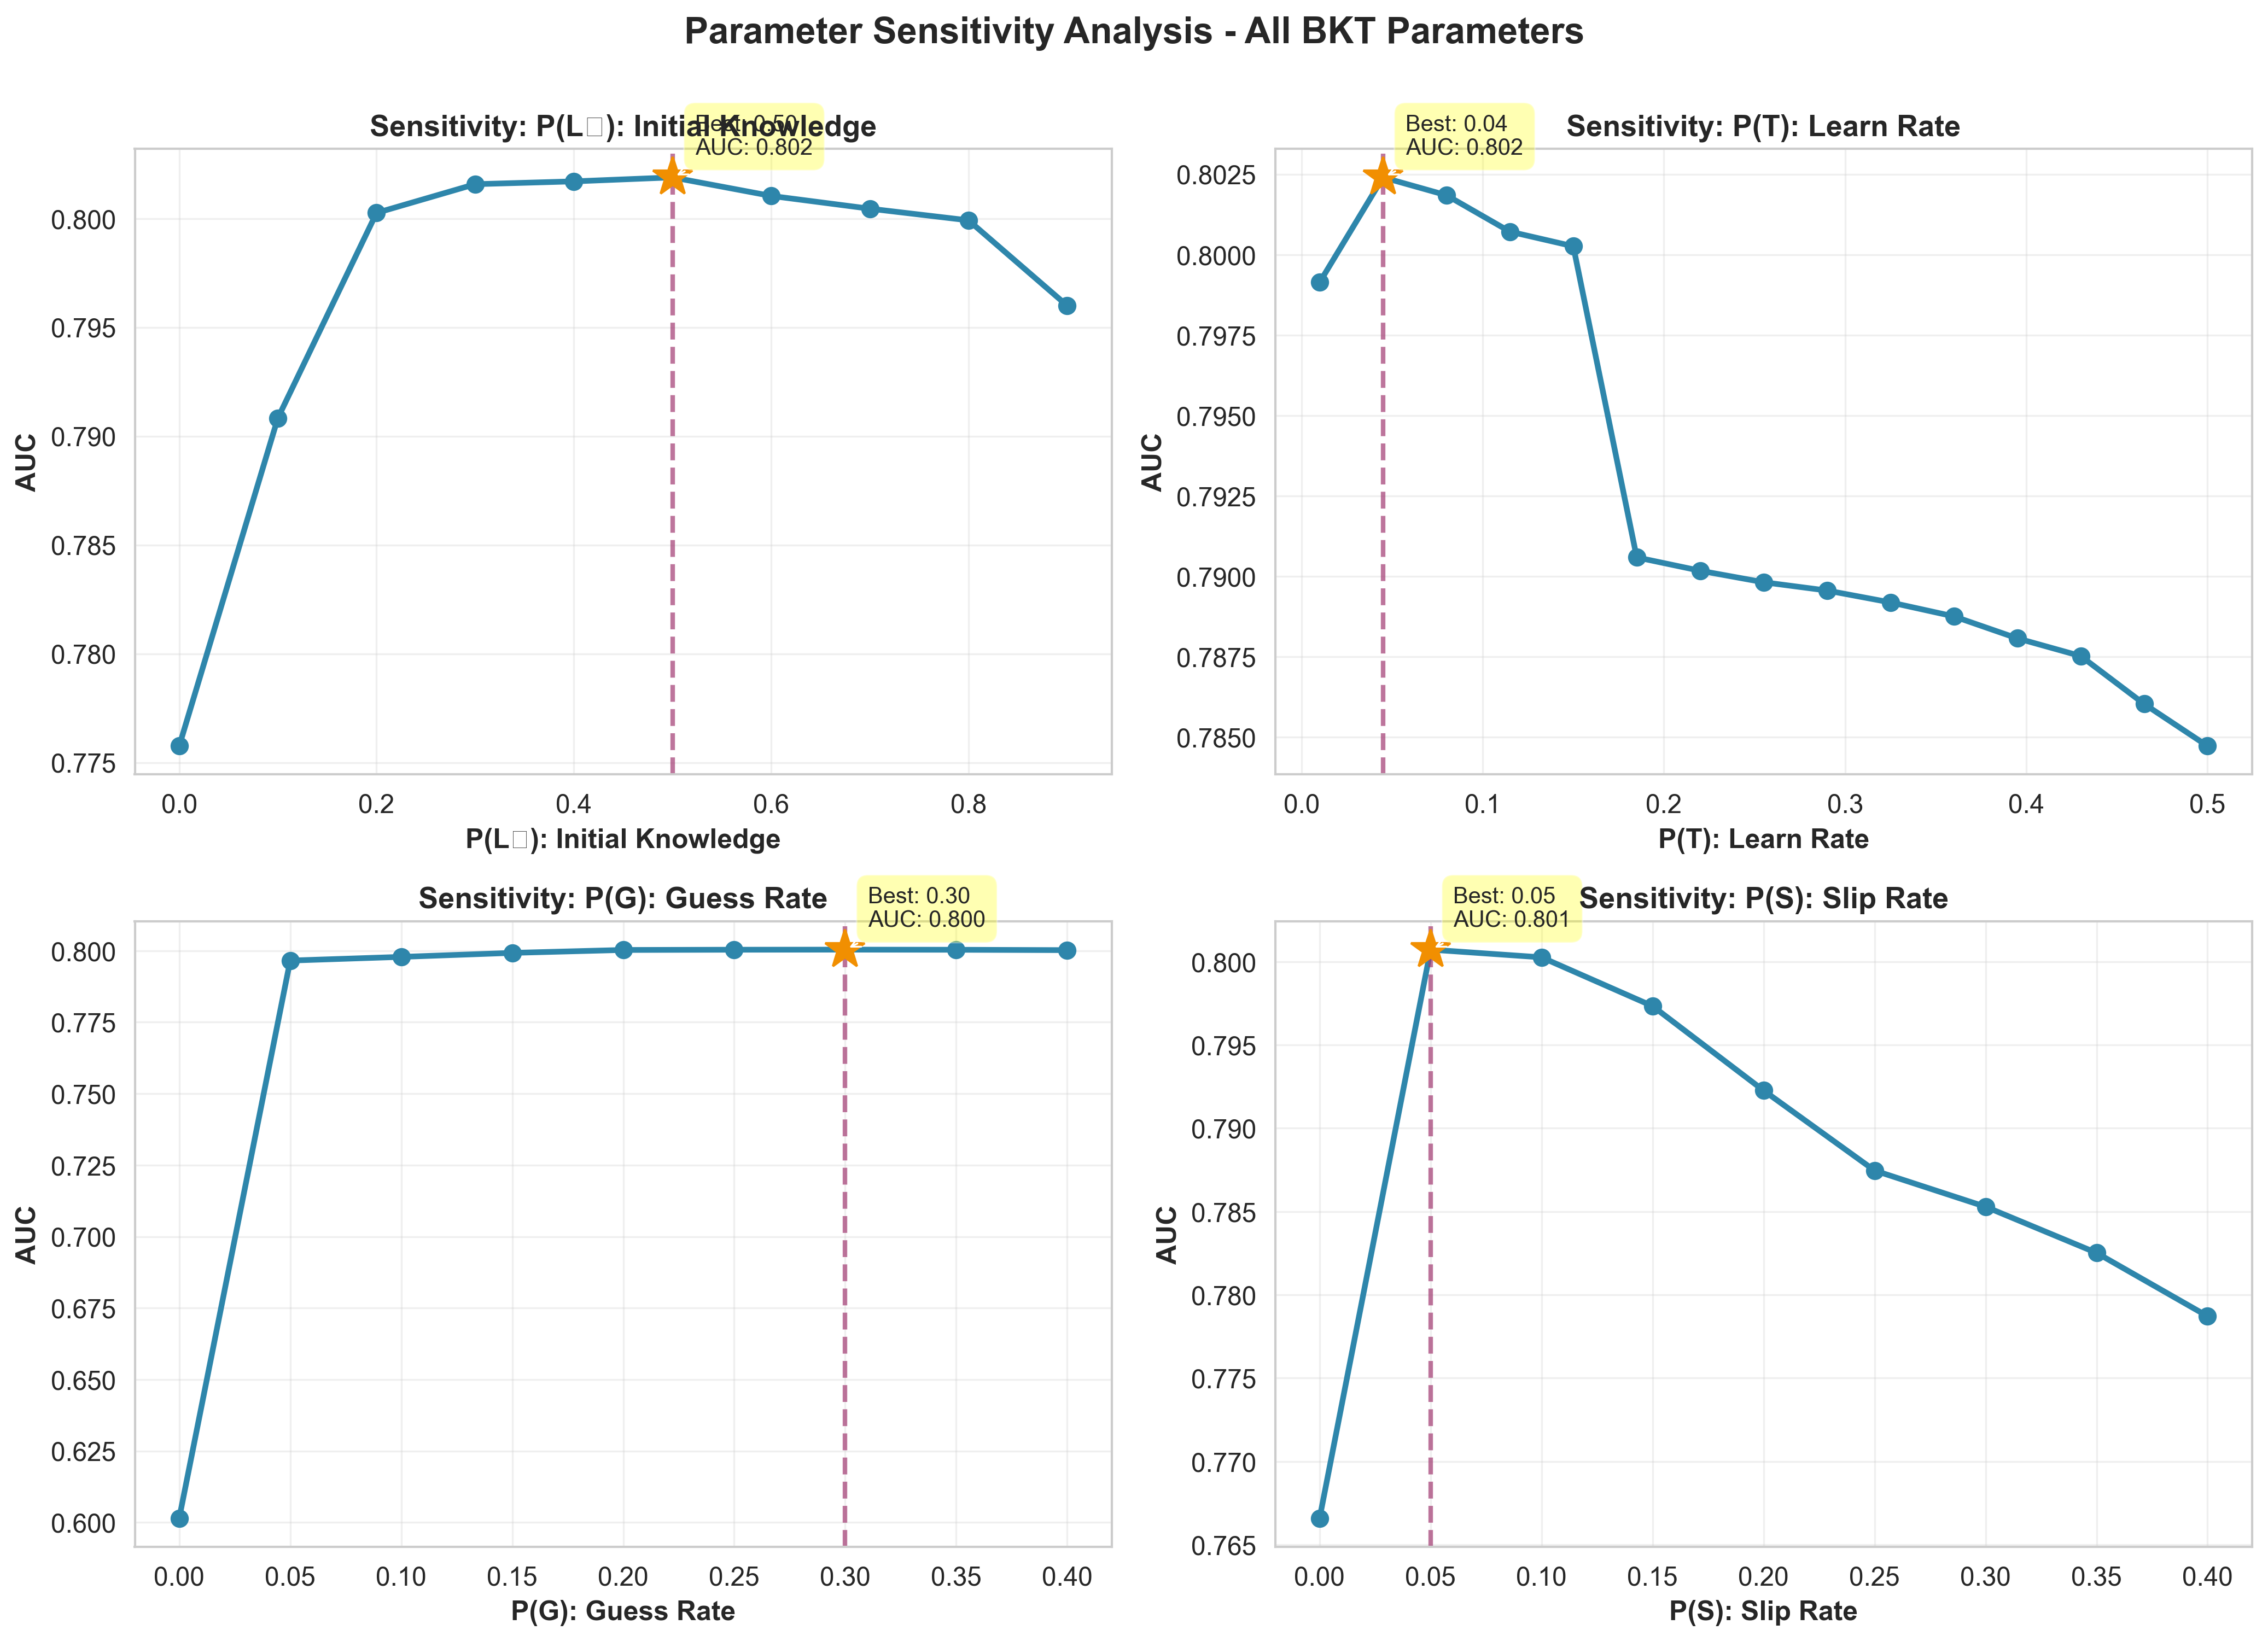

c:\Users\Windows 11\Desktop\RofProject\SeniorProject\calculus-enhancement-platform\backend\bkt_experiments\analysis\visualizations.py:343: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Windows 11\Desktop\RofProject\SeniorProject\calculus-enhancement-platform\backend\bkt_experiments\analysis\visualizations.py:344: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig(save_path, bbox_inches='tight', dpi=300)


Summary figure saved to: ../results/notebook_experiment/recommendations.png


c:\Users\Windows 11\Desktop\RofProject\SeniorProject\calculus-enhancement-platform\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


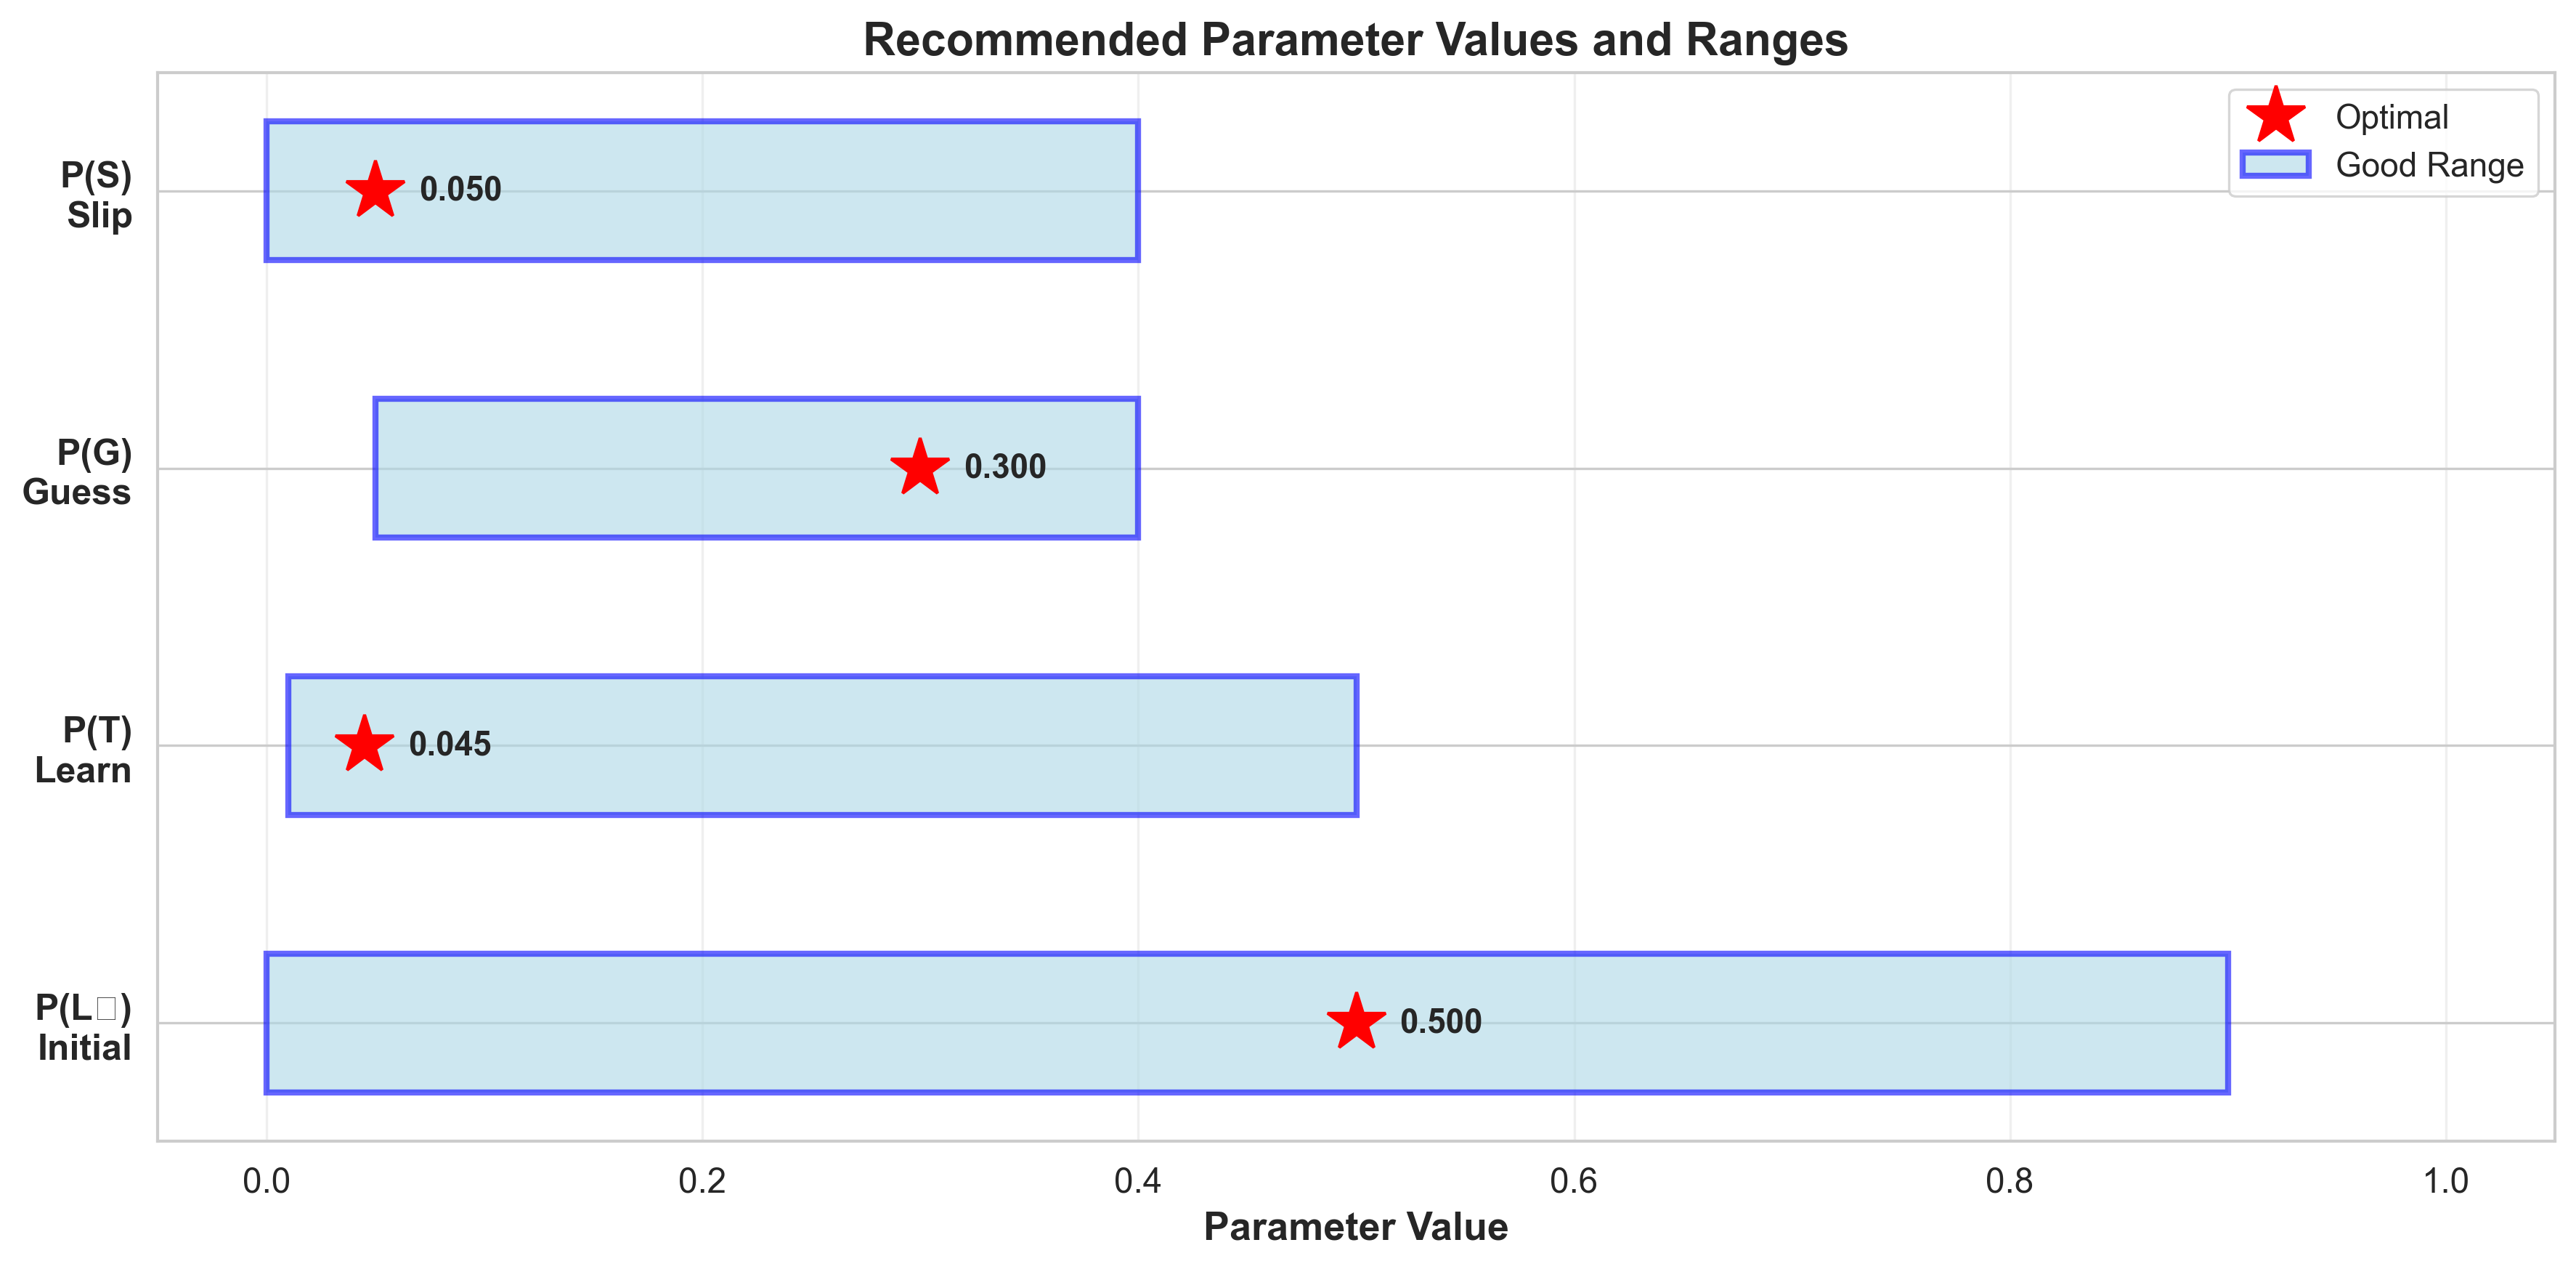

Success


In [12]:
# Uncomment to run full analysis
all_sweeps = exp.run_all_parameter_sweeps(dataset, verbose=True)

# Visualize all parameters
plot_all_parameter_sensitivities(all_sweeps, save_dir='../results/notebook_experiment/figures')

# Generate recommendations
recommendations = exp.generate_recommendations(all_sweeps)
create_summary_report_figure(recommendations, save_path='../results/notebook_experiment/recommendations.png')

print("Success")

## 7. Parameter Interaction Analysis

Analyze how P(L0) and P(T) interact.

In [13]:
# Run interaction analysis (smaller grid for speed)
interaction_df = exp.run_parameter_interaction_analysis(
    param1_name='p_init',
    param2_name='p_learn',
    param1_range=np.linspace(0.1, 0.7, 7).tolist(),
    param2_range=np.linspace(0.05, 0.35, 7).tolist(),
    dataset=dataset,
    verbose=True
)


Parameter Interaction Analysis: p_init × p_learn
Testing 7 × 7 = 49 combinations



Grid search: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


Results saved to: ..\results\notebook_experiment\interaction_p_init_vs_p_learn.csv


Saved to: ../results/notebook_experiment/init_vs_learn_heatmap.png


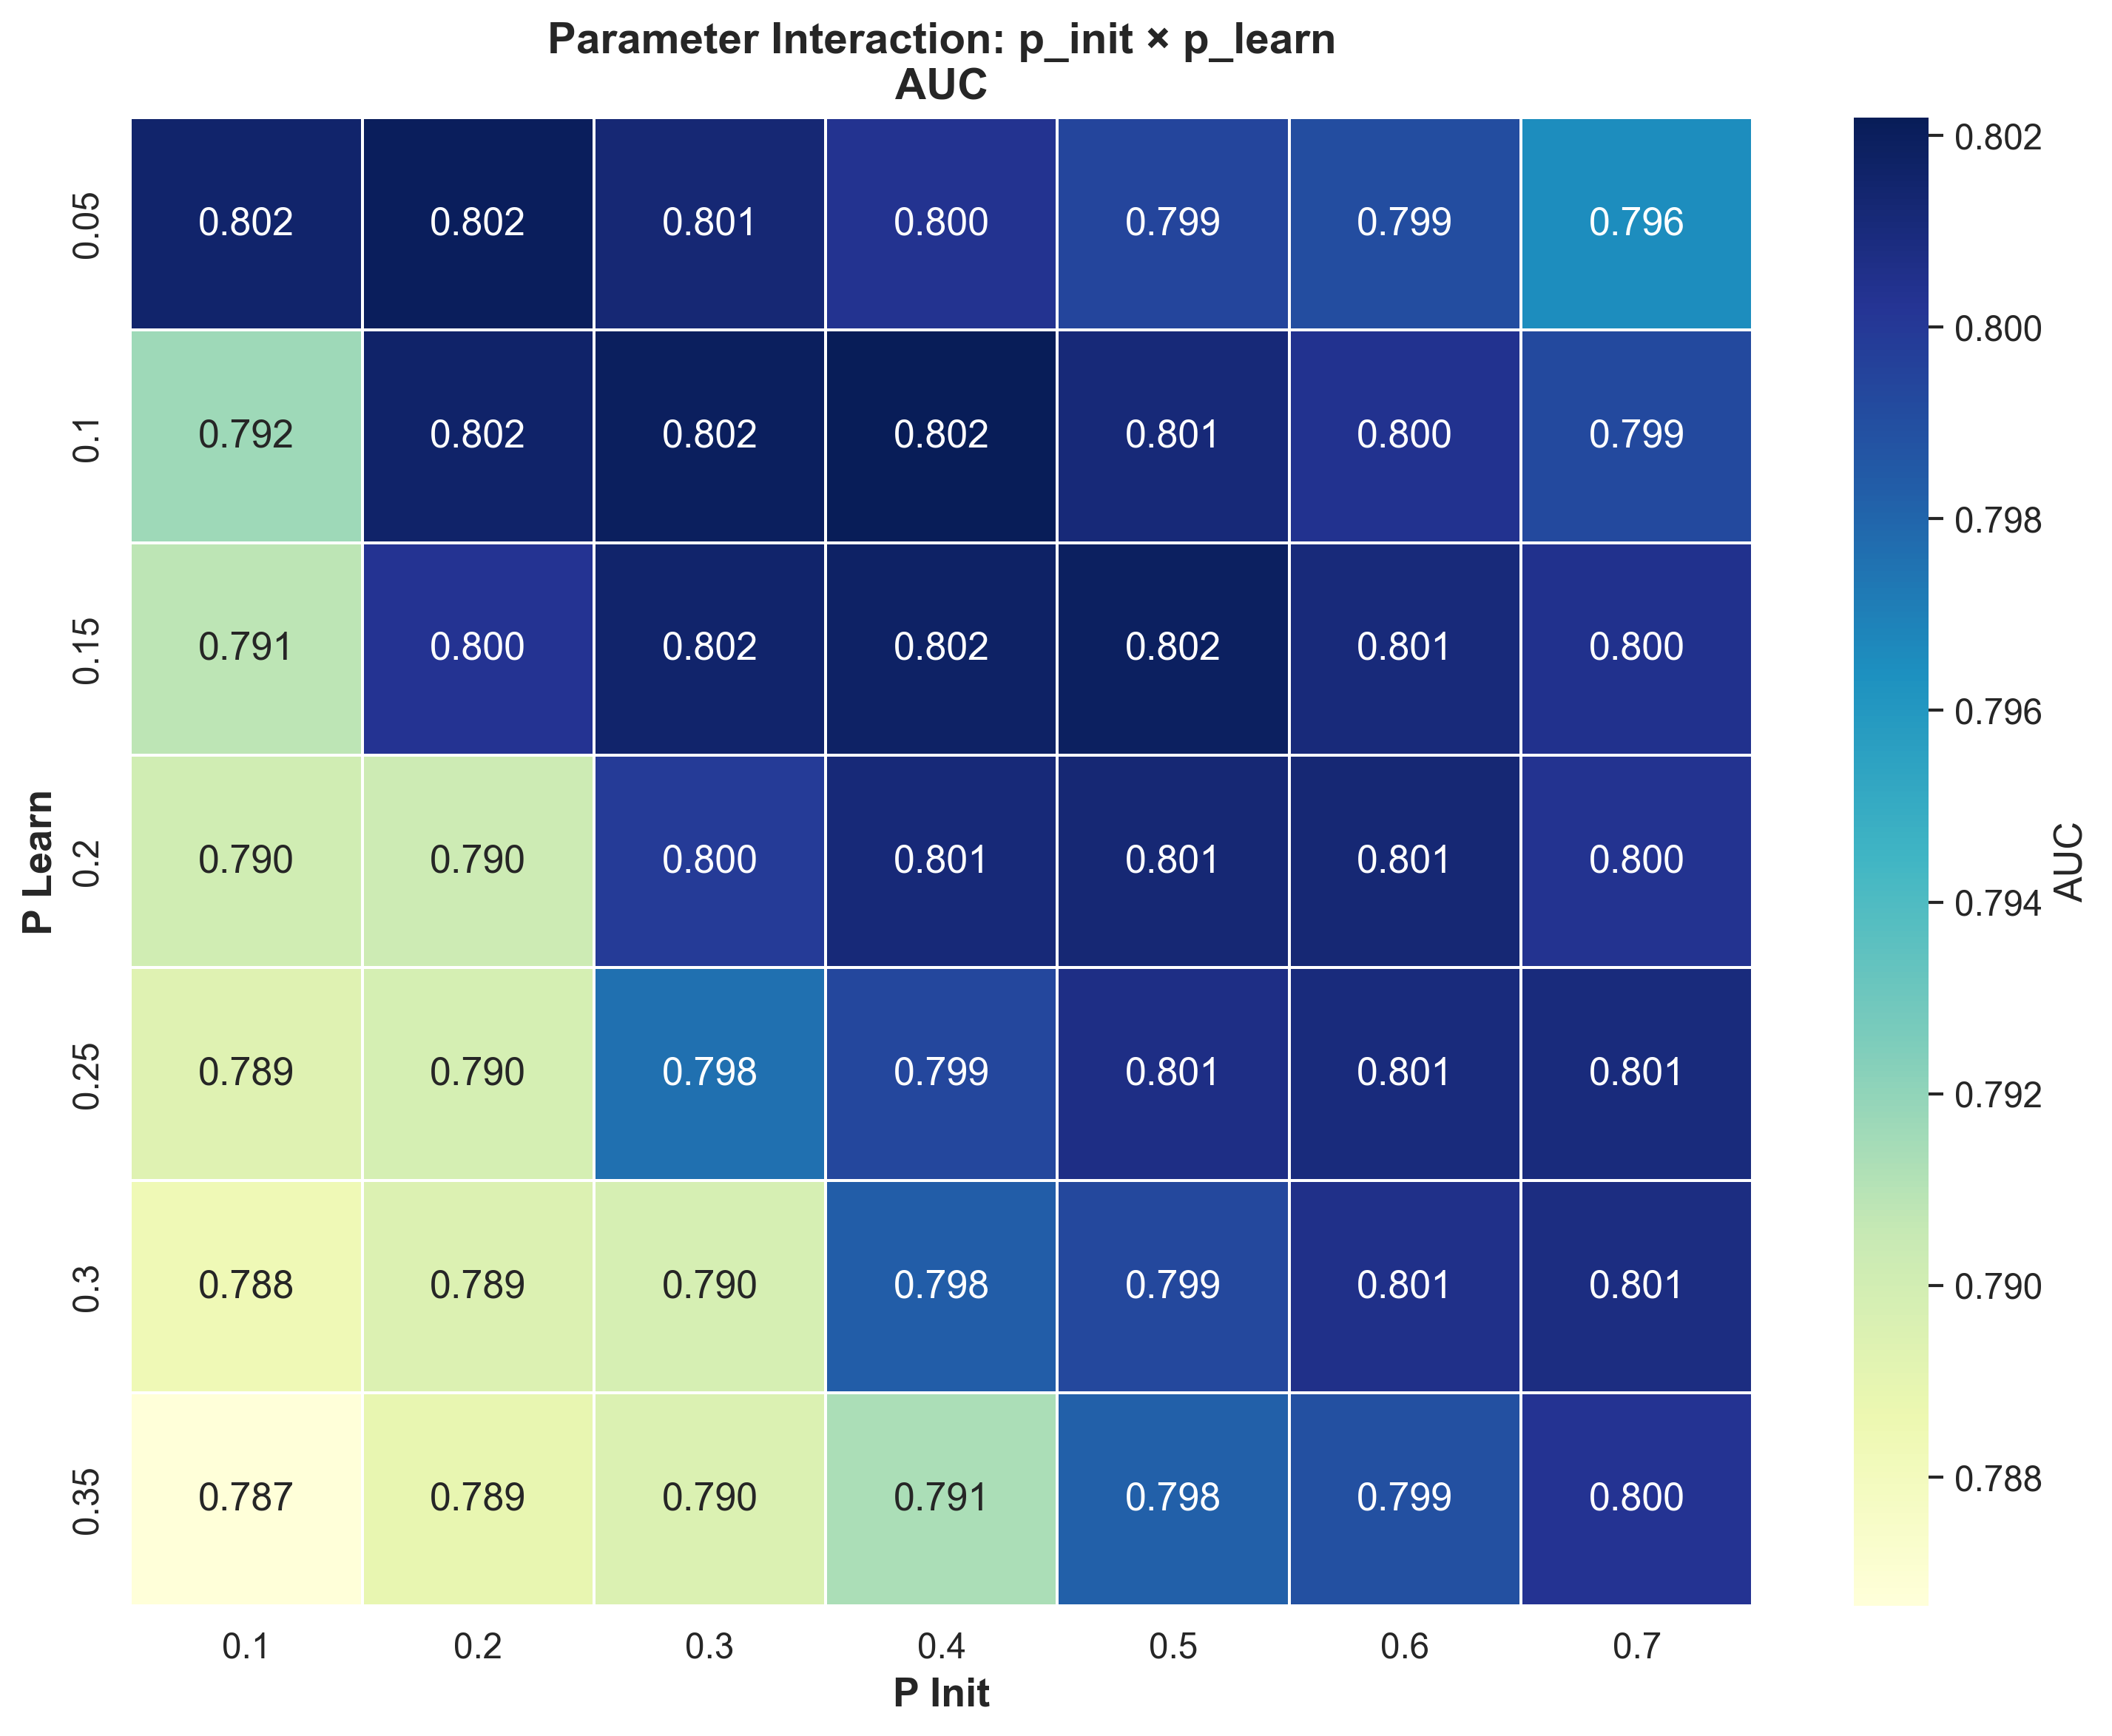

In [14]:
# Visualize interaction
plot_parameter_interaction_heatmap(
    df=interaction_df,
    param1_name='p_init',
    param2_name='p_learn',
    metric='auc',
    save_path='../results/notebook_experiment/init_vs_learn_heatmap.png'
)

## 8. Test Extreme Parameters

What happens when parameters are extreme?

In [ ]:
extreme_results = exp.analyze_extreme_values(dataset, verbose=True)

# Convert to DataFrame for better display
extreme_df = pd.DataFrame([
    {
        'Scenario': scenario,
        'Success': result['success'],
        'AUC': result.get('metrics', {}).get('auc', 'N/A') if result['success'] else 'FAILED',
        'Accuracy': result.get('metrics', {}).get('accuracy', 'N/A') if result['success'] else 'FAILED'
    }
    for scenario, result in extreme_results.items()
])

print("\nExtreme Value Results:")
print(extreme_df.to_string(index=False))


Extreme Value Analysis

Testing: all_low
  Params: {'p_init': 0.01, 'p_learn': 0.01, 'p_guess': 0.01, 'p_slip': 0.01}
  AUC: 0.7898, Accuracy: 0.7461

Testing: all_high
  Params: {'p_init': 0.9, 'p_learn': 0.4, 'p_guess': 0.4, 'p_slip': 0.4}
  AUC: 0.7174, Accuracy: 0.6255

Testing: high_init_only
  Params: {'p_init': 0.9, 'p_learn': 0.1, 'p_guess': 0.15, 'p_slip': 0.1}
  AUC: 0.7954, Accuracy: 0.7198

Testing: high_learn_only
  Params: {'p_init': 0.2, 'p_learn': 0.45, 'p_guess': 0.15, 'p_slip': 0.1}
  AUC: 0.7867, Accuracy: 0.6441

Testing: high_guess_slip
  Params: {'p_init': 0.2, 'p_learn': 0.15, 'p_guess': 0.38, 'p_slip': 0.38}
  AUC: 0.7698, Accuracy: 0.7089

Testing: no_learning
  Params: {'p_init': 0.2, 'p_learn': 0.0, 'p_guess': 0.2, 'p_slip': 0.1}
  AUC: 0.7573, Accuracy: 0.6756

Testing: perfect_learner
  Params: {'p_init': 0.1, 'p_learn': 0.5, 'p_guess': 0.05, 'p_slip': 0.02}
  AUC: 0.7889, Accuracy: 0.6343

Results saved to: ..\results\notebook_experiment\extreme_values_an

: 

## Next Steps

1. Explore different datasets (vary num_students, num_skills)
2. Try custom parameters with specific research questions
3. Compare with ground-truth datasets using `generate_simple_dataset`
4. Implement additional BKT variants (forgetting, individualized)

## Resources

- See `README.md` for full documentation
- Run `demo.py` for command-line examples
- Check `experiments/parameter_sensitivity.py` for more analysis options